In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphicsb

pd.set_option('display.max_rows', None)

In [2]:
allData = pd.DataFrame()

# Adding initial condition
initialData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Initial')
allData = allData.append(initialData, ignore_index=True)

# Adding speed increase condition
speedIncData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Speed Increase')
allData = allData.append(speedIncData, ignore_index=True)

# Adding speed decrease condition
speedDecData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Speed Decrease')
allData = allData.append(speedDecData, ignore_index=True)

# Adding position increase condition
posIncData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Position Increase')
allData = allData.append(posIncData, ignore_index=True)

# Adding position decrease condition
posDecData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Position Decrease')
allData = allData.append(posDecData, ignore_index=True)

# Adding temp increase original condition
tempIncAData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Temp Increase A')
allData = allData.append(tempIncAData, ignore_index=True)

# Adding temp increase changed condition
tempIncBData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Temp Increase B')
allData = allData.append(tempIncBData, ignore_index=True)

# Adding temp decrease original condition
tempDecAData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Temp Decrease A')
allData = allData.append(tempDecAData, ignore_index=True)

# Adding temp decrease changed condition
tempDecBData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Temp Decrease B')
allData = allData.append(tempDecBData, ignore_index=True)

# Adding melt decrease original condition
meltDecAData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Melt Decrease A')
allData = allData.append(meltDecAData, ignore_index=True)

# Adding melt decrease changed condition
meltDecBData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Melt Decrease B')
allData = allData.append(meltDecBData, ignore_index=True)

allData.head()

,CYCLE TIME,INJECT TIME,INJECT POSITION,MAX PRESSURE,METER TIME,CHANGE PRESSURE,CHANGE POSITION,CONDITION
0,50.07,1.62,2.60,121.5,8.78,891,12.99,Initial
1,35.06,1.62,2.55,124.0,9.05,896,12.99,Initial
2,34.02,1.62,2.39,121.7,8.86,898,13.00,Initial
3,0.00,1.62,2.32,122.1,0.00,894,12.99,Initial
4,38.88,1.62,2.68,124.2,8.79,903,12.99,Initial


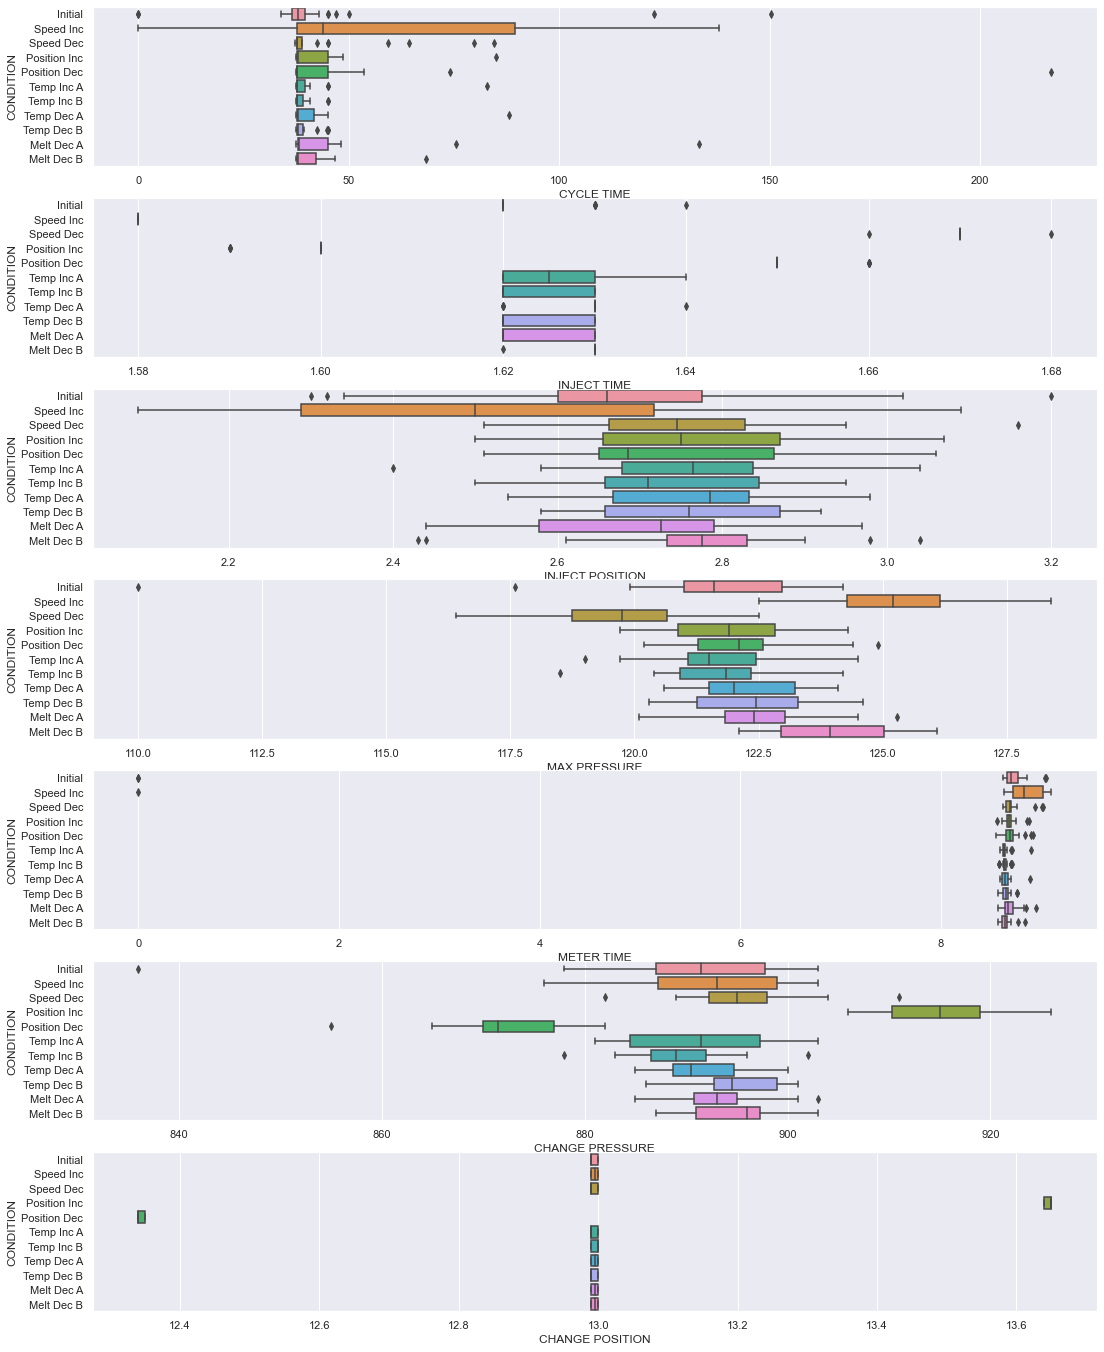

In [3]:
# Extract Response and Predictors
y = pd.DataFrame(allData["CONDITION"].astype('category'))
X = pd.DataFrame(allData[["CYCLE TIME", "INJECT TIME", "INJECT POSITION", "MAX PRESSURE", "METER TIME", "CHANGE PRESSURE", "CHANGE POSITION"]])

# Relationship between Response and the Predictors
trainDF = pd.concat([y, X.reindex(index=y.index)], sort = False, axis = 1)

f, axes = plt.subplots(7, 1, figsize=(18, 24))

conditionOrder = ["Initial", "Speed Inc", "Speed Dec", "Position Inc", "Position Dec", "Temp Inc A", "Temp Inc B", "Temp Dec A", "Temp Dec B", "Melt Dec A", "Melt Dec B"]
count = 0
for var in X:
    sb.boxplot(x = var, y = "CONDITION", data = trainDF, orient = "h", ax = axes[count], order = conditionOrder)
    count += 1

Classification Accuracy 	: 1.0



<AxesSubplot:>

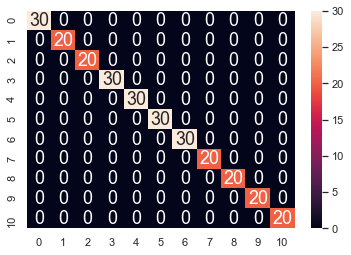

In [4]:
# Import Decision Tree Classifier model from Scikit-Learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# Decision Tree using Train Data
dectree = DecisionTreeClassifier()
dectree.fit(X, y)

# Predict Response corresponding to Predictors
y_pred = dectree.predict(X)

# Check the Goodness of Fit
print("Classification Accuracy \t:", dectree.score(X, y))
print()

# Plot the Confusion Matrix for Train and Test
sb.heatmap(confusion_matrix(y, y_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})





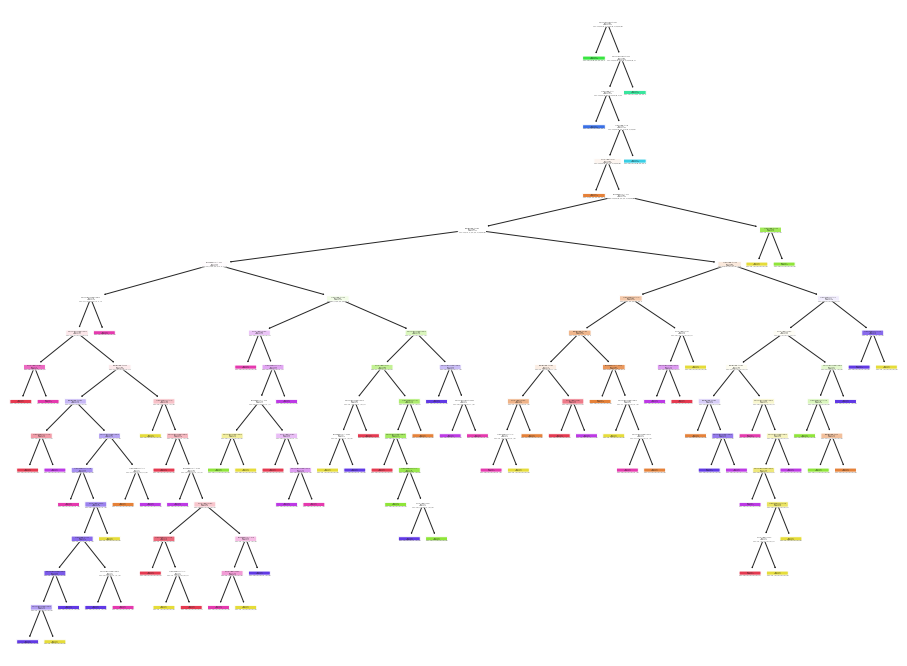

In [5]:
# Plot the Decision Tree model
from sklearn.tree import plot_tree
f, axes = plt.subplots(1, 1, figsize=(16, 12))

plot_tree(dectree, filled=True, rounded = True, 
          feature_names=X.columns)
plt.show()

In [6]:
# Adding initial condition
testData = pd.read_excel('data/Injection Molding Data.xlsx', sheet_name = 'Testing')

# testData = testData.drop(columns="CONDITION")
testData.head()

,CYCLE TIME,INJECT TIME,INJECT POSITION,MAX PRESSURE,METER TIME,CHANGE PRESSURE,CHANGE POSITION,CONDITION
0,37.53,1.62,2.61,122.5,8.75,898,13.00,Initial
1,39.93,1.62,2.66,122.9,8.71,901,13.00,Initial
2,33.85,1.62,3.20,122.7,8.70,895,12.99,Initial
3,150.36,1.62,2.30,123.4,9.04,898,12.99,Initial
4,34.21,1.62,2.72,117.6,8.80,880,13.00,Initial


In [7]:
import statistics

groupSize = 10

start = 1
end = groupSize


meanDF = pd.DataFrame()

try:
    while True:
        dataGroupCycleTime = []
        dataGroupInjectTime = []
        dataGroupInjectPosition = []
        dataGroupMaxPressure = []
        dataGroupMeterTime = []
        dataGroupChangePressure = []
        dataGroupChangePosition = []

        for i in range(start - 1, end):
            dataGroupCycleTime.append(testData["CYCLE TIME"].iloc[i])
            dataGroupInjectTime.append(testData["INJECT TIME"].iloc[i])
            dataGroupInjectPosition.append(testData["INJECT POSITION"].iloc[i])
            dataGroupMaxPressure.append(testData["MAX PRESSURE"].iloc[i])
            dataGroupMeterTime.append(testData["METER TIME"].iloc[i])
            dataGroupChangePressure.append(testData["CHANGE PRESSURE"].iloc[i])
            dataGroupChangePosition.append(testData["CHANGE POSITION"].iloc[i])


        meanCycleTime = statistics.mean(dataGroupCycleTime)
        meanInjectTime = statistics.mean(dataGroupInjectTime)
        meanInjectPosition = statistics.mean(dataGroupInjectPosition)
        meanMaxPressure = statistics.mean(dataGroupMaxPressure)
        meanMeterTime = statistics.mean(dataGroupMeterTime)
        meanChangePressure = statistics.mean(dataGroupChangePressure)
        meanChangePosition = statistics.mean(dataGroupChangePosition)

        newRow = [{ 'MEAN CYCLE TIME': meanCycleTime, 
                    'MEAN INJECT TIME': meanInjectTime, 
                    'MEAN INJECT POSITION': meanInjectPosition, 
                    'MEAN MAX PRESSURE': meanMaxPressure, 
                    'MEAN METER TIME': meanMeterTime, 
                    'MEAN CHANGE PRESSURE': meanChangePressure, 
                    'MEAN CHANGE POSITION': meanChangePosition}]

        meanDF = meanDF.append(newRow, ignore_index=True)

        start += 1
        end += 1

except IndexError:
    pass


# Predict response for the points
y_pred = dectree.predict(meanDF)

currentCondition = testData["CONDITION"][meanDF.index + groupSize - 1].to_numpy()
currentCondition = pd.DataFrame(currentCondition, columns = ["LATEST CONDITION"], index = meanDF.index)
jointDF = pd.concat([meanDF,currentCondition], axis = 1)

# Concatenate with the given data
y_pred = pd.DataFrame(y_pred, columns = ["PREDICTED CONDITION"], index = meanDF.index)
jointDF = pd.concat([jointDF,y_pred], axis = 1)
jointDF


,MEAN CYCLE TIME,MEAN INJECT TIME,MEAN INJECT POSITION,MEAN MAX PRESSURE,MEAN METER TIME,MEAN CHANGE PRESSURE,MEAN CHANGE POSITION,LATEST CONDITION,PREDICTED CONDITION
0,44.689,1.621,2.666,120.18,7.879,884,12.994,Initial,Temp Inc A
1,45.438,1.621,2.681,120.29,7.876,883,12.994,Initial,Temp Inc A
2,45.333,1.622,2.678,120.39,7.871,883,12.994,Initial,Temp Inc A
3,45.532,1.622,2.647,120.24,7.866,882,12.994,Initial,Temp Inc A
4,35.187,1.622,2.677,120.05,7.844,881,12.995,Initial,Initial
5,44.027,1.624,2.666,120.28,7.832,881,12.994,Initial,Temp Inc A
6,47.928,1.624,2.630,121.50,8.701,886,12.994,Initial,Temp Dec B
7,47.884,1.624,2.680,121.67,8.699,888,12.993,Initial,Temp Dec B
8,47.945,1.624,2.701,121.65,8.693,888,12.993,Initial,Initial
9,47.819,1.624,2.721,121.70,8.692,888,12.994,Initial,Initial
